# <font color='red'>Catch it, if you can</font>

### Import libraries

In [1]:
import graphviz
import pydot
import scipy

#import pydotplus #need of this only on University computer

from numpy import linalg as LA
from tqdm import tqdm 
from scipy.sparse.linalg import eigs
import random as rnd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import math
import copy
import csv
import os
import sys
import json
import seaborn as sns
sns.set_context('paper')
from matplotlib.font_manager import FontProperties as FP

np.set_printoptions(threshold=sys.maxsize)

In [2]:
%matplotlib inline

full_marker = ['.','o','s','v','h','^','p','>','1','2','3','*']

font_scale = FP().copy()
font_scale.set_style('normal')
font_scale.set_weight('semibold')
font_scale.set_size(12)


font_text = FP().copy()
font_text.set_style('normal')
font_text.set_weight('bold')
font_text.set_size(16)

### Generating a random graph

In [3]:
###This routine returns the stochastic matrix, the degree list, the node list associated to the GCC of an ER graph.

def ER_Graph(N,c):
    Graph = nx.fast_gnp_random_graph(N,c/N) #fast routine for sparse graphs
    GCC = max(nx.connected_component_subgraphs(Graph), key=len)
    deg_list = np.asarray(list(dict(GCC.degree()).values()))
    #print(deg_list)
    nod_list = np.asarray(GCC.nodes())
    #print(nod_list)
    Pi = np.dot(np.diag(1/deg_list),np.asarray(nx.adjacency_matrix(GCC).todense()))
    #print(Pi)
    
    #Exporting the stochastic matrix
    
    writeToThis1 = open('StochMatr50', 'w')
    writeToThis1.write('\n'.join('\t'.join('%0.3f' %x for x in y) for y in Pi))
    writeToThis1.close()
    with open('DegList50', 'w') as f:
        for item in list(deg_list):
            f.write("%s\n" % item)
    with open('NodList50', 'w') as f:
        for item in list(nod_list):
            f.write("%s\n" % item)

    incomplete_adj_list = [[int(s) for s in line.split(' ')] for line in nx.generate_adjlist(GCC)]
    complete_adj_list = copy.deepcopy(incomplete_adj_list)
    for i in range(len(complete_adj_list)):
        for j in range(len(complete_adj_list[i])):
            if complete_adj_list[i][0] not in complete_adj_list[list(nod_list).index(complete_adj_list[i][j])]:
                complete_adj_list[list(nod_list).index(complete_adj_list[i][j])].append(complete_adj_list[i][0])
    shortest_paths = nx.shortest_path_length(GCC)
    dict_shortest_paths = dict(shortest_paths)
    
    with open('AdjList50', 'w') as f:
        for item in complete_adj_list:
            f.write("%s\n" % item)
    with open('ShortPath50.json', 'w') as f:
        f.write(json.dumps(dict_shortest_paths))
    
    return Pi, deg_list, nod_list, GCC, complete_adj_list, dict_shortest_paths

In [4]:
N = 1000
alpha = 3.5
G = ER_Graph(N,alpha)

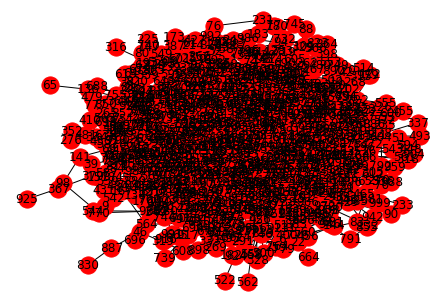

In [51]:
import warnings
warnings.filterwarnings("ignore")

### The following is needed on university computer. On my laptop there is no need.
#import os
#os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\pkgs\graphviz-2.38.0-4\Library\bin\graphviz"

### Graphical layout

f = plt.figure()
pos_graphviz = nx.nx_pydot.graphviz_layout(G[3])
nx.draw(G[3], pos=pos_graphviz, with_labels = True)
#f.savefig("graphAsynchronous.png")

### Adaptive Random Walk

In [5]:
def a(it,alpha):
    return math.pow(1/(1+it),alpha)

def ARW_step(Pi,Pi_n,r,deg_list,nod_list,ann_sch,last_node_ind,it,fixed_ind,emp_measure):
    
    np.set_printoptions(precision=2)
    
    #Initializing variables
    alpha = [0.01,0.05,0.1]
    emp_measure = [0 for i in range(len(Pi))]
     
    if(it==0):
        r_old = [rnd.random() for i in range(len(nod_list))]
        r_new = copy.deepcopy(r_old)
        Pi_n = copy.deepcopy(Pi)
        #Starting node and fixed node
        nextnode = rnd.choice(nod_list) #pick a distinguished node i_0
        next_ind = list(nod_list).index(nextnode) #its index in the list
        emp_measure[next_ind] += 1
        fixed_ind = next_ind

    if(it != 0):
        r_old = copy.deepcopy(r)
        r_new = copy.deepcopy(r_old)
        start_ind = copy.deepcopy(last_node_ind)

        ###step 1: adaptive step in finding the effective process (effective process update)
        for j in range(len(Pi)):
            Pi_n[start_ind,j] = Pi[start_ind,j]*r_old[j]
        Pi_n[start_ind] = Pi_n[start_ind]/sum(Pi_n[start_ind])

        ###step 2: pick a random index according to the n-th effective process
        next_ind = rnd.choices(range(len(Pi)),Pi_n[start_ind])[0]
        emp_measure[next_ind] += 1

        ###step 3: right eigenvector update
        r_new[start_ind] = r_old[start_ind] +a(it,alpha[ann_sch])*(deg_list[start_ind]*np.dot(Pi[start_ind],r_old)/r_old[fixed_ind]-r_old[start_ind])

        ### Node story update
        fixed_ind = emp_measure.index(max(emp_measure))

        #stat_distr[:] = [x / max_it for x in stat_distr]

    return nod_list[next_ind], next_ind, fixed_ind, r_new, Pi_n, emp_measure

### Unbiased Random Walk

In [6]:
def URW_step(Pi,deg_list,nod_list,last_node_ind,it):
    np.set_printoptions(precision=2)
    
    #Initializing variables
    if(it==0):
        #Starting node and fixed node
        nextnode = rnd.choice(nod_list) #pick a distinguished node i_0
        next_ind = list(nod_list).index(nextnode) #its index in the list
    else:
        start_ind = copy.deepcopy(last_node_ind)
        ###step: pick a random index according to the URW transition matrix
        next_ind = rnd.choices(range(len(Pi)),Pi[start_ind])[0]

    return nod_list[next_ind],next_ind

### Maximum Entropy Random Walk

In [9]:
def MERW_step(PiMERW,deg_list,nod_list,last_node_ind,it):
    np.set_printoptions(precision=2)
    
    #Initializing variables
    if(it==0):
        #Starting node and fixed node
        nextnode = rnd.choice(nod_list) #pick a distinguished node i_0
        next_ind = list(nod_list).index(nextnode) #its index in the list
    else:
        start_ind = copy.deepcopy(last_node_ind)
        ###step: pick a random index according to the URW transition matrix
        next_ind = rnd.choices(range(len(PiMERW)),PiMERW[start_ind])[0]

    return next_ind

In [10]:
### Creating PiMERW for our graph

def EigenSys_Num(Pi,deg_list):
    
    PiMERW = [[0 for j in range(len(Pi[i]))] for i in range(len(Pi))]
    Pi_s = np.dot(np.diag(np.asarray(deg_list)),Pi)
    
    eig_syst_s = scipy.linalg.eig(Pi_s, left=True, right=True)
    ind_dom_eigv = list(eig_syst_s[0]).index(max(np.real(eig_syst_s[0])))
    #print(eig_syst_s[0])
    #print(ind_dom_eigv)
    left_eigvec = np.real(eig_syst_s[1][:,ind_dom_eigv])/sum(np.real(eig_syst_s[1][:,ind_dom_eigv]))
    right_eigvec = np.real(eig_syst_s[2][:,ind_dom_eigv])
    #print(eig_syst_s[1][:,ind_dom_eigv])
    #print(eig_syst_s[2][:,ind_dom_eigv])

    ###Note: here eigenvectors are normalised as in QM (sum of square is 1). We want a different normalisation (sum is 1).
    left_eigvec_norm = left_eigvec/sum(left_eigvec)
    right_eigvec_norm = right_eigvec/sum(right_eigvec)
    stat_distr = (left_eigvec_norm * right_eigvec_norm)/sum(left_eigvec_norm * right_eigvec_norm)
    
    for i in range(len(Pi)):
        for j in range(len(Pi[i])):
            PiMERW = Pi_s[i,j]*right_eigvec_norm[j]/(right_eigvec_norm[i]*max(np.real(eig_syst_s[0])))

    return PiMERW

### Main

#### ARW VS URW

In [13]:
### 1 Jack the Ripper moving as an ARW, 5 detectives, each move detectives ask around them in turns, if they spot a track 
### in the next step they will all move towards the track, deterministically, and then start diffusing (as URW) around it again to catch 
### Jack

### Initialising positions

MaxIt = 10000
Detective_number = 2

Pi = G[0]
deg_list = G[1] #indexed
nod_list = G[2] #actual nodes indexed
adj_list = G[4] #actual nodes
dict_short_path = nx.shortest_path(G[3]) #actual nodes
ann_sch = 2
HowManySim = 1
AvCaughtARW = 0
warm_up = 1


for Sim_RW in tqdm(range(HowManySim)):
    it = 0
    Detective_pos = [list() for i in range(Detective_number)] 
    Jack_pos = list()
    Spotted = 0
    Caught = 0
    while (it <= MaxIt):
        #print(it)
        if(it==0):
            last_node_ind_ARW = 0
            last_node_ind_URW = [0 for i in range(Detective_number)]
            Pi_n = 0
            r = 0
            fixed_ind = 0
            emp_measure = 0

            # first move Jack and warm up

            Jack = ARW_step(Pi,Pi_n,r,deg_list,nod_list,ann_sch,last_node_ind_ARW,it,fixed_ind,emp_measure)
            for w in range(warm_up):
                Jack = ARW_step(Pi,Jack[4],Jack[3],deg_list,nod_list,ann_sch,Jack[1],it,Jack[2],Jack[5])
                
            Jack_pos.append(Jack[0]) #actual nodes

            # Detective moves 

            Detective_ind = [0 for i in range(Detective_number)]
            for i in range(Detective_number):
                Detective = URW_step(Pi,deg_list,nod_list,last_node_ind_URW[i],it)
                Detective_pos[i].append(Detective[0]) #actual nodes
                Detective_ind[i] = Detective[1] #indexes

            # Detective investigations
            ToFollow = [0 for i in range(Detective_number)]
            ToFollowHowMany = [0 for i in range(Detective_number)]
            for i in range(Detective_number):
                for j in range(deg_list[Detective_ind[i]]):
                    if(adj_list[Detective_ind[i]][j+1] in Jack_pos): #as soon as one detective spots something, investigation stops
                        Spotted = 1
                        #print("Spotted in %d"%adj_list[Detective_ind[i]][j+1])
                        if(adj_list[Detective_ind[i]][j+1] == Jack_pos[-1]):
                            Caught = 1
                            #print("Caught in %d"%adj_list[Detective_ind[i]][j+1])
                        else:
                            for k in range(Detective_number):
                                if(k!=i):
                                    ToFollow[k] = dict_short_path[Detective_pos[k][-1]][adj_list[Detective_ind[i]][j+1]][1:-1]
                                    ToFollowHowMany[k] = len(ToFollow[k])
                        break
                if(Spotted == 1 or Caught == 1):
                    break
        else:
            # move Jack

            Jack = ARW_step(Pi,Jack[4],Jack[3],deg_list,nod_list,ann_sch,Jack[1],it,Jack[2],Jack[5])
            Jack_pos.append(Jack[0]) #actual nodes

            if(Spotted == 0): #if it was not spotted, all investigators keep moving randomly

                # Detective moves 

                for i in range(Detective_number):
                    Detective = URW_step(Pi,deg_list,nod_list,Detective_ind[i],it)
                    Detective_pos[i].append(Detective[0])
                    Detective_ind[i] = Detective[1]

            else: #if spotted=1 investigators move deterministically following ToFollow path

                # Detective moves

                for i in range(Detective_number):
                    if(ToFollowHowMany[i] != 0):
                        Detective_pos[i].append(ToFollow[i][0])
                        Detective_ind[i] = list(nod_list).index(Detective_pos[i][-1])
                        ToFollow[i].pop(0)
                        ToFollowHowMany[i] -= 1
                    else:
                        Detective = URW_step(Pi,deg_list,nod_list,Detective_ind[i],it)
                        Detective_pos[i].append(Detective[0])
                        Detective_ind[i] = Detective[1]
                if(sum(ToFollowHowMany)==0):
                    Spotted = 0

            # and they then investigate
            for i in range(Detective_number):
                for j in range(deg_list[Detective_ind[i]]):
                    if(adj_list[Detective_ind[i]][j+1] in Jack_pos): #as soon as one detective spots something, investigation stops
                        Spotted = 1
                        #print("Spotted in %d"%adj_list[Detective_ind[i]][j+1])
                        if(adj_list[Detective_ind[i]][j+1] == Jack_pos[-1]):
                            Caught = 1
                            #print("Caught in %d"%adj_list[Detective_ind[i]][j+1])
                        else:
                            for k in range(Detective_number):
                                if(k!=i):
                                    ToFollow[k] = dict_short_path[Detective_pos[k][-1]][adj_list[Detective_ind[i]][j+1]][1:-1]
                                    ToFollowHowMany[k] = len(ToFollow[k])
                        break
                if(Spotted == 1 or Caught == 1):
                    break
        if(Caught == 1):
            AvCaughtARW += it
            break;
        it+=1
    #if(Caught==1):
    #    print("Caught in %d"%it+" moves")
print(AvCaughtARW/(1.0*HowManySim))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


149.0


In [14]:
len(set(Jack_pos)),len(Jack_pos)

(32, 150)

#### URW VS URW

In [73]:
### 1 Jack the Ripper moving as an ARW, 5 detectives, each move detectives ask around them in turns, if they spot a track 
### in the next step they will all move towards the track, deterministically, and then start diffusing (as URW) around it again to catch 
### Jack

### Initialising positions

MaxIt = 10000
Detective_number = 2

Pi = G[0]
deg_list = G[1] #indexed
nod_list = G[2] #actual nodes indexed
adj_list = G[4] #actual nodes
dict_short_path = nx.shortest_path(G[3]) #actual nodes
HowManySim = 3000
AvCaughtURW = 0


for Sim_RW in tqdm(range(HowManySim)):
    it = 0
    Detective_pos = [list() for i in range(Detective_number)] 
    Jack_pos = list()
    Spotted = 0
    Caught = 0
    while (it <= MaxIt):
        #print(it)
        if(it==0):
            last_node_ind_URW_Jack = 0
            last_node_ind_URW = [0 for i in range(Detective_number)]
            fixed_ind = 0
            emp_measure = 0

            # first move Jack

            Jack = URW_step(Pi,deg_list,nod_list,last_node_ind_URW_Jack,it)
            Jack_pos.append(Jack[0]) #actual nodes

            # Detective moves 

            Detective_ind = [0 for i in range(Detective_number)]
            for i in range(Detective_number):
                Detective = URW_step(Pi,deg_list,nod_list,last_node_ind_URW[i],it)
                Detective_pos[i].append(Detective[0]) #actual nodes
                Detective_ind[i] = Detective[1] #indexes

            # Detective investigations
            ToFollow = [0 for i in range(Detective_number)]
            ToFollowHowMany = [0 for i in range(Detective_number)]
            for i in range(Detective_number):
                for j in range(deg_list[Detective_ind[i]]):
                    if(adj_list[Detective_ind[i]][j+1] in Jack_pos): #as soon as one detective spots something, investigation stops
                        Spotted = 1
                        #print("Spotted in %d"%adj_list[Detective_ind[i]][j+1])
                        if(adj_list[Detective_ind[i]][j+1] == Jack_pos[-1]):
                            Caught = 1
                            #print("Caught in %d"%adj_list[Detective_ind[i]][j+1])
                        else:
                            for k in range(Detective_number):
                                if(k!=i):
                                    ToFollow[k] = dict_short_path[Detective_pos[k][-1]][adj_list[Detective_ind[i]][j+1]][1:-1]
                                    ToFollowHowMany[k] = len(ToFollow[k])
                        break
                if(Spotted == 1 or Caught == 1):
                    break
        else:
            # move Jack

            Jack = URW_step(Pi,deg_list,nod_list,Jack[1],it)
            Jack_pos.append(Jack[0]) #actual nodes

            if(Spotted == 0): #if it was not spotted, all investigators keep moving randomly

                # Detective moves 

                for i in range(Detective_number):
                    Detective = URW_step(Pi,deg_list,nod_list,Detective_ind[i],it)
                    Detective_pos[i].append(Detective[0])
                    Detective_ind[i] = Detective[1]

            else: #if spotted=1 investigators move deterministically following ToFollow path

                # Detective moves

                for i in range(Detective_number):
                    if(ToFollowHowMany[i] != 0):
                        Detective_pos[i].append(ToFollow[i][0])
                        Detective_ind[i] = list(nod_list).index(Detective_pos[i][-1])
                        ToFollow[i].pop(0)
                        ToFollowHowMany[i] -= 1
                    else:
                        Detective = URW_step(Pi,deg_list,nod_list,Detective_ind[i],it)
                        Detective_pos[i].append(Detective[0])
                        Detective_ind[i] = Detective[1]
                if(sum(ToFollowHowMany)==0):
                    Spotted = 0

            # and they then investigate
            for i in range(Detective_number):
                for j in range(deg_list[Detective_ind[i]]):
                    if(adj_list[Detective_ind[i]][j+1] in Jack_pos): #as soon as one detective spots something, investigation stops
                        Spotted = 1
                        #print("Spotted in %d"%adj_list[Detective_ind[i]][j+1])
                        if(adj_list[Detective_ind[i]][j+1] == Jack_pos[-1]):
                            Caught = 1
                            #print("Caught in %d"%adj_list[Detective_ind[i]][j+1])
                        else:
                            for k in range(Detective_number):
                                if(k!=i):
                                    ToFollow[k] = dict_short_path[Detective_pos[k][-1]][adj_list[Detective_ind[i]][j+1]][1:-1]
                                    ToFollowHowMany[k] = len(ToFollow[k])
                        break
                if(Spotted == 1 or Caught == 1):
                    break
        if(Caught == 1):
            AvCaughtURW += it
            break;
        it+=1
    #if(Caught==1):
    #    print("Caught in %d"%it+" moves")
print(AvCaughtURW/(1.0*HowManySim))






  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]




  0%|                                                                                 | 2/3000 [00:01<33:25,  1.50it/s]




  0%|                                                                                 | 3/3000 [00:01<31:21,  1.59it/s]




  0%|▏                                                                                | 5/3000 [00:02<24:35,  2.03it/s]




  0%|▏                                                                                | 6/3000 [00:02<26:32,  1.88it/s]




  0%|▏                                                                                | 7/3000 [00:03<21:02,  2.37it/s]




  0%|▏                                                                                | 9/3000 [00:03<15:51,  3.14it/s]




  0%|▎                                                                               | 10/3000 [00:03<14:34,  3.42it/s]




  0

  7%|█████▌                                                                         | 212/3000 [01:24<13:22,  3.47it/s]




  7%|█████▋                                                                         | 214/3000 [01:24<12:09,  3.82it/s]




  7%|█████▋                                                                         | 215/3000 [01:24<10:45,  4.31it/s]




  7%|█████▋                                                                         | 216/3000 [01:26<28:11,  1.65it/s]




  7%|█████▋                                                                         | 217/3000 [01:26<22:25,  2.07it/s]




  7%|█████▊                                                                         | 219/3000 [01:26<16:56,  2.73it/s]




  7%|█████▊                                                                         | 220/3000 [01:28<42:16,  1.10it/s]




  7%|█████▊                                                                         | 222/3000 [01:29<34:13,  1.35it/s]




  7%|███

 14%|██████████▊                                                                    | 411/3000 [02:43<15:28,  2.79it/s]




 14%|██████████▊                                                                    | 412/3000 [02:43<12:32,  3.44it/s]




 14%|██████████▉                                                                    | 415/3000 [02:44<12:47,  3.37it/s]




 14%|██████████▉                                                                    | 417/3000 [02:44<10:07,  4.25it/s]




 14%|███████████                                                                    | 418/3000 [02:44<08:30,  5.05it/s]




 14%|███████████                                                                    | 420/3000 [02:45<08:50,  4.87it/s]




 14%|███████████                                                                    | 422/3000 [02:45<07:42,  5.57it/s]




 14%|███████████▏                                                                   | 425/3000 [02:46<09:10,  4.68it/s]




 14%|███

 20%|████████████████                                                               | 611/3000 [03:54<10:57,  3.63it/s]




 20%|████████████████                                                               | 612/3000 [03:55<24:42,  1.61it/s]




 20%|████████████████▏                                                              | 613/3000 [03:55<18:44,  2.12it/s]




 20%|████████████████▏                                                              | 614/3000 [03:56<14:26,  2.75it/s]




 20%|████████████████▏                                                              | 615/3000 [03:56<17:13,  2.31it/s]




 21%|████████████████▏                                                              | 617/3000 [03:56<12:42,  3.12it/s]




 21%|████████████████▎                                                              | 618/3000 [03:57<15:09,  2.62it/s]




 21%|████████████████▎                                                              | 620/3000 [03:58<18:25,  2.15it/s]




 21%|███

 27%|█████████████████████▍                                                         | 812/3000 [05:06<21:40,  1.68it/s]




 27%|█████████████████████▍                                                         | 813/3000 [05:07<21:08,  1.72it/s]




 27%|█████████████████████▍                                                         | 815/3000 [05:07<15:27,  2.36it/s]




 27%|█████████████████████▌                                                         | 817/3000 [05:07<11:37,  3.13it/s]




 27%|█████████████████████▌                                                         | 818/3000 [05:07<09:27,  3.84it/s]




 27%|█████████████████████▌                                                         | 819/3000 [05:07<07:55,  4.59it/s]




 27%|█████████████████████▌                                                         | 820/3000 [05:08<10:05,  3.60it/s]




 27%|█████████████████████▌                                                         | 821/3000 [05:08<11:28,  3.16it/s]




 27%|███

 34%|██████████████████████████▋                                                   | 1028/3000 [06:17<05:24,  6.07it/s]




 34%|██████████████████████████▊                                                   | 1030/3000 [06:17<04:46,  6.87it/s]




 34%|██████████████████████████▊                                                   | 1031/3000 [06:19<18:17,  1.79it/s]




 34%|██████████████████████████▉                                                   | 1034/3000 [06:19<14:12,  2.31it/s]




 35%|██████████████████████████▉                                                   | 1036/3000 [06:20<10:29,  3.12it/s]




 35%|██████████████████████████▉                                                   | 1038/3000 [06:20<08:19,  3.93it/s]




 35%|███████████████████████████                                                   | 1039/3000 [06:20<07:22,  4.43it/s]




 35%|███████████████████████████                                                   | 1041/3000 [06:20<05:57,  5.47it/s]




 35%|███

 42%|████████████████████████████████▋                                             | 1257/3000 [07:37<06:06,  4.75it/s]




 42%|████████████████████████████████▋                                             | 1259/3000 [07:37<05:11,  5.59it/s]




 42%|████████████████████████████████▊                                             | 1261/3000 [07:37<05:04,  5.71it/s]




 42%|████████████████████████████████▊                                             | 1263/3000 [07:38<08:23,  3.45it/s]




 42%|████████████████████████████████▉                                             | 1266/3000 [07:39<08:27,  3.42it/s]




 42%|████████████████████████████████▉                                             | 1269/3000 [07:40<07:17,  3.96it/s]




 42%|█████████████████████████████████                                             | 1271/3000 [07:40<07:03,  4.08it/s]




 42%|█████████████████████████████████                                             | 1272/3000 [07:40<06:39,  4.32it/s]




 42%|███

 49%|██████████████████████████████████████▌                                       | 1481/3000 [08:46<06:57,  3.64it/s]




 49%|██████████████████████████████████████▌                                       | 1482/3000 [08:46<06:51,  3.69it/s]




 49%|██████████████████████████████████████▌                                       | 1483/3000 [08:48<23:16,  1.09it/s]




 50%|██████████████████████████████████████▌                                       | 1485/3000 [08:49<19:38,  1.29it/s]




 50%|██████████████████████████████████████▋                                       | 1487/3000 [08:50<17:03,  1.48it/s]




 50%|██████████████████████████████████████▋                                       | 1488/3000 [08:50<12:51,  1.96it/s]




 50%|██████████████████████████████████████▋                                       | 1489/3000 [08:51<13:43,  1.84it/s]




 50%|██████████████████████████████████████▋                                       | 1490/3000 [08:51<12:49,  1.96it/s]




 50%|███

 57%|████████████████████████████████████████████                                  | 1696/3000 [09:55<12:39,  1.72it/s]




 57%|████████████████████████████████████████████▏                                 | 1698/3000 [09:55<09:24,  2.31it/s]




 57%|████████████████████████████████████████████▏                                 | 1701/3000 [09:56<07:01,  3.08it/s]




 57%|████████████████████████████████████████████▎                                 | 1702/3000 [09:56<07:11,  3.01it/s]




 57%|████████████████████████████████████████████▎                                 | 1703/3000 [09:57<10:08,  2.13it/s]




 57%|████████████████████████████████████████████▎                                 | 1706/3000 [09:58<10:00,  2.15it/s]




 57%|████████████████████████████████████████████▍                                 | 1707/3000 [09:58<08:26,  2.55it/s]




 57%|████████████████████████████████████████████▍                                 | 1709/3000 [09:59<07:04,  3.04it/s]




 57%|███

 64%|█████████████████████████████████████████████████▋                            | 1909/3000 [11:00<01:46, 10.25it/s]




 64%|█████████████████████████████████████████████████▋                            | 1911/3000 [11:01<02:34,  7.03it/s]




 64%|█████████████████████████████████████████████████▋                            | 1912/3000 [11:01<03:20,  5.44it/s]




 64%|█████████████████████████████████████████████████▊                            | 1914/3000 [11:02<05:13,  3.46it/s]




 64%|█████████████████████████████████████████████████▊                            | 1916/3000 [11:03<04:28,  4.04it/s]




 64%|█████████████████████████████████████████████████▉                            | 1919/3000 [11:03<03:54,  4.62it/s]




 64%|█████████████████████████████████████████████████▉                            | 1921/3000 [11:03<03:14,  5.55it/s]




 64%|█████████████████████████████████████████████████▉                            | 1922/3000 [11:04<04:45,  3.77it/s]




 64%|███

 71%|███████████████████████████████████████████████████████▏                      | 2124/3000 [12:11<06:15,  2.33it/s]




 71%|███████████████████████████████████████████████████████▎                      | 2125/3000 [12:11<05:20,  2.73it/s]




 71%|███████████████████████████████████████████████████████▎                      | 2127/3000 [12:13<08:14,  1.77it/s]




 71%|███████████████████████████████████████████████████████▎                      | 2128/3000 [12:13<07:04,  2.06it/s]




 71%|███████████████████████████████████████████████████████▎                      | 2129/3000 [12:14<06:55,  2.10it/s]




 71%|███████████████████████████████████████████████████████▍                      | 2130/3000 [12:14<06:42,  2.16it/s]




 71%|███████████████████████████████████████████████████████▍                      | 2131/3000 [12:14<05:17,  2.74it/s]




 71%|███████████████████████████████████████████████████████▍                      | 2132/3000 [12:15<04:52,  2.96it/s]




 71%|███

 78%|█████████████████████████████████████████████████████████████                 | 2348/3000 [13:26<03:52,  2.80it/s]




 78%|█████████████████████████████████████████████████████████████                 | 2350/3000 [13:26<03:01,  3.57it/s]




 78%|█████████████████████████████████████████████████████████████▏                | 2354/3000 [13:26<02:17,  4.70it/s]




 79%|█████████████████████████████████████████████████████████████▎                | 2357/3000 [13:26<02:01,  5.29it/s]




 79%|█████████████████████████████████████████████████████████████▍                | 2361/3000 [13:27<02:00,  5.30it/s]




 79%|█████████████████████████████████████████████████████████████▍                | 2362/3000 [13:28<03:13,  3.29it/s]




 79%|█████████████████████████████████████████████████████████████▍                | 2363/3000 [13:28<04:26,  2.39it/s]




 79%|█████████████████████████████████████████████████████████████▍                | 2364/3000 [13:29<05:50,  1.81it/s]




 79%|███

 85%|██████████████████████████████████████████████████████████████████▍           | 2557/3000 [14:30<02:06,  3.51it/s]




 85%|██████████████████████████████████████████████████████████████████▌           | 2558/3000 [14:30<02:17,  3.21it/s]




 85%|██████████████████████████████████████████████████████████████████▌           | 2561/3000 [14:31<01:49,  4.01it/s]




 85%|██████████████████████████████████████████████████████████████████▋           | 2563/3000 [14:31<01:29,  4.88it/s]




 85%|██████████████████████████████████████████████████████████████████▋           | 2564/3000 [14:31<01:43,  4.21it/s]




 86%|██████████████████████████████████████████████████████████████████▋           | 2565/3000 [14:31<01:29,  4.86it/s]




 86%|██████████████████████████████████████████████████████████████████▋           | 2566/3000 [14:32<01:55,  3.77it/s]




 86%|██████████████████████████████████████████████████████████████████▋           | 2567/3000 [14:32<01:46,  4.05it/s]




 86%|███

 92%|███████████████████████████████████████████████████████████████████████▋      | 2759/3000 [15:37<01:35,  2.53it/s]




 92%|███████████████████████████████████████████████████████████████████████▊      | 2760/3000 [15:43<08:11,  2.05s/it]




 92%|███████████████████████████████████████████████████████████████████████▊      | 2762/3000 [15:43<05:46,  1.46s/it]




 92%|███████████████████████████████████████████████████████████████████████▊      | 2763/3000 [15:44<04:09,  1.05s/it]




 92%|███████████████████████████████████████████████████████████████████████▉      | 2765/3000 [15:44<03:13,  1.22it/s]




 92%|███████████████████████████████████████████████████████████████████████▉      | 2766/3000 [15:45<03:12,  1.22it/s]




 92%|███████████████████████████████████████████████████████████████████████▉      | 2769/3000 [15:45<02:15,  1.70it/s]




 92%|████████████████████████████████████████████████████████████████████████      | 2771/3000 [15:45<01:45,  2.16it/s]




 92%|███

 99%|█████████████████████████████████████████████████████████████████████████████▍| 2976/3000 [17:07<00:15,  1.52it/s]




 99%|█████████████████████████████████████████████████████████████████████████████▍| 2978/3000 [17:08<00:13,  1.69it/s]




 99%|█████████████████████████████████████████████████████████████████████████████▍| 2980/3000 [17:08<00:08,  2.32it/s]




 99%|█████████████████████████████████████████████████████████████████████████████▌| 2982/3000 [17:08<00:06,  2.98it/s]




100%|█████████████████████████████████████████████████████████████████████████████▋| 2986/3000 [17:09<00:03,  3.81it/s]




100%|█████████████████████████████████████████████████████████████████████████████▋| 2988/3000 [17:09<00:02,  4.31it/s]




100%|█████████████████████████████████████████████████████████████████████████████▋| 2990/3000 [17:09<00:01,  5.49it/s]




100%|█████████████████████████████████████████████████████████████████████████████▊| 2992/3000 [17:10<00:01,  4.94it/s]




100%|███

382.456
